In [7]:
from causalml.dataset import synthetic_data
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, LRSRegressor, BaseDRLearner, MLPTRegressor, BaseRLearner, BaseSRegressor
from xgboost import XGBRegressor
import pandas as pd
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Read in Ace data
ace_data = pd.read_csv('ace_data.csv')

# y, X, treatment, _, _, e = synthetic_data(mode=1, n=1000, p=5, sigma=1.0)

# # Print the shape of the data
# print(X.shape)
# print(y.shape)
# print(treatment.shape)

In [8]:
# Get the column names of ace_data
column_names = ace_data.columns
print(column_names)

Index(['FINALWT', 'GENHLTH', 'MARITAL', '_SEX', 'MENTHLTH', '_EDUCAG',
       '_INCOMG1', 'POORHLTH', 'ADDEPEV3', '_AGEG5YR', '_AGE65YR', '_AGE80',
       '_AGE_G', 'DECIDE', 'DIFFALON', 'ACEDEPRS', 'ACEDRINK', 'ACEDRUGS',
       'ACEPRISN', 'ACEDIVRC', 'ACEPUNCH', 'ACEHURT1', 'ACESWEAR', 'ACETOUCH',
       'ACETTHEM', 'ACEHVSEX'],
      dtype='object')


In [9]:
# Declare the list of treatments with multiple levels
multi_levels = ['ACEPUNCH', 'ACEHURT1', 'ACESWEAR', 'ACETOUCH', 'ACETTHEM', 'ACEHVSEX']

In [10]:
def perform_analysis(data, target_col, treatment_col, feature_cols, sample_weights_col='FINALWT'):
    # Drop NAs in the treatment and target columns
    data = data.dropna(subset=[treatment_col, target_col])
    
    # Initialize a list to store results
    results = []
    output_csv = 'output.csv'
    # Filter out unwanted responses depending on the treatment
    if treatment_col == 'ACEDIVRC':
        # Create a dictionary mapping the recoded treatment levels to their original labels
        treatment_labels = {0: 'No', 1: 'Yes', 2: 'Parents not married'}

        # Keep only the responses that are 1, 2, or 8 (1 = Yes, 2 = No, 8 = Not Married)
        data = data[data[treatment_col].isin([1, 2, 8])]
        # Recode the treatment variables
        data[treatment_col] = data[treatment_col].map({1: 1, 2: 0, 8: 2})
        
        # Control group information
        control = treatment_labels[0]
        
        # Declare the treatment and target
        treatment = data[treatment_col]
        y = data[target_col]

        # Declare X
        X = data[feature_cols]
        
        # Declare the sample weights
        sample_weights = data[sample_weights_col]
        
        # Perform the analysis -----------------------------------------
        
        # Estimate the ATE using the LRS Regressor
        learner_s = LRSRegressor()
        te, lb, ub = learner_s.estimate_ate(X=X, treatment=treatment, y=y)
        for treatment_level in range(len(te)):
            results.append([treatment_col, target_col, 'LRS Regressor', control, treatment_labels[treatment_level + 1], te[treatment_level], lb[treatment_level], ub[treatment_level]])

        # Estimate the ATE using the Neural Network (MLP)
        nn = MLPTRegressor(hidden_layer_sizes=(10, 10), learning_rate_init=.1, early_stopping=True, random_state=42)
        te, lb, ub = nn.estimate_ate(X, treatment, y)
        for treatment_level in range(len(te)):
            results.append([treatment_col, target_col, 'Neural Network (MLP)', control, treatment_labels[treatment_level + 1], te[treatment_level], lb[treatment_level], ub[treatment_level]])

        # Estimate the ATE using the BaseXRegressor
        xl = BaseXRegressor(learner=XGBRegressor(random_state=42))
        te, lb, ub = xl.estimate_ate(X, treatment, y)
        for treatment_level in range(len(te)):
            results.append([treatment_col, target_col, 'BaseXRegressor (XGBoost)', control, treatment_labels[treatment_level + 1], te[treatment_level], lb[treatment_level], ub[treatment_level]])
        
        # Estimate the ATE using the BaseDRLearner
        dr = BaseDRLearner(learner=XGBRegressor(random_state=42))
        te, lb, ub = dr.estimate_ate(X, treatment, y)
        for treatment_level in range(len(te)):
            results.append([treatment_col, target_col, 'BaseDRLearner (XGBoost)', control, treatment_labels[treatment_level + 1], te[treatment_level], lb[treatment_level], ub[treatment_level]])

        # Estimate the ATE using the BaseRLearner
        rl = BaseRLearner(learner=XGBRegressor(random_state=42))
        te, lb, ub = rl.estimate_ate(X, treatment, y)
        for treatment_level in range(len(te)):
            results.append([treatment_col, target_col, 'BaseRLearner (XGBoost)', control, treatment_labels[treatment_level + 1], te[treatment_level], lb[treatment_level], ub[treatment_level]])

    elif treatment_col in multi_levels:
        # Create a dictionary mapping the recoded treatment levels to their original labels
        treatment_labels = {0: 'Never', 1: 'Once', 2: 'More than once'}
        
        # Control group information
        control = treatment_labels[0]
        
        # Keep only the responses that are 1 or 2 or 3 (1 = Never, 2 = Once, 3 = More than once)
        data = data[data[treatment_col].isin([1, 2, 3])]
        # Recode the treatment and target variables
        data[treatment_col] = data[treatment_col].map({1: 0, 2: 1, 3: 2})
        
        # Declare the treatment and target
        treatment = data[treatment_col]
        y = data[target_col]

        # Declare X
        X = data[feature_cols]
        
        # Declare the sample weights
        sample_weights = data[sample_weights_col]

        # Perform the analysis -----------------------------------------
        
        # Estimate the ATE using the LRS Regressor
        learner_s = LRSRegressor()
        te, lb, ub = learner_s.estimate_ate(X=X, treatment=treatment, y=y)
        for treatment_level in range(len(te)):
            results.append([treatment_col, target_col, 'LRS Regressor', control, treatment_labels[treatment_level + 1], te[treatment_level], lb[treatment_level], ub[treatment_level]])

        # Estimate the ATE using the Neural Network (MLP)
        nn = MLPTRegressor(hidden_layer_sizes=(10, 10), learning_rate_init=.1, early_stopping=True, random_state=42)
        te, lb, ub = nn.estimate_ate(X, treatment, y)
        for treatment_level in range(len(te)):
            results.append([treatment_col, target_col, 'Neural Network (MLP)', control, treatment_labels[treatment_level + 1], te[treatment_level], lb[treatment_level], ub[treatment_level]])

        # Estimate the ATE using the BaseXRegressor
        xl = BaseXRegressor(learner=XGBRegressor(random_state=42))
        te, lb, ub = xl.estimate_ate(X, treatment, y)
        for treatment_level in range(len(te)):
            results.append([treatment_col, target_col, 'BaseXRegressor (XGBoost)', control, treatment_labels[treatment_level + 1], te[treatment_level], lb[treatment_level], ub[treatment_level]])
        
        # Estimate the ATE using the BaseDRLearner
        dr = BaseDRLearner(learner=XGBRegressor(random_state=42))
        te, lb, ub = dr.estimate_ate(X, treatment, y)
        for treatment_level in range(len(te)):
            results.append([treatment_col, target_col, 'BaseDRLearner (XGBoost)', control, treatment_labels[treatment_level + 1], te[treatment_level], lb[treatment_level], ub[treatment_level]])

        # Estimate the ATE using the BaseRLearner
        rl = BaseRLearner(learner=XGBRegressor(random_state=42))
        te, lb, ub = rl.estimate_ate(X, treatment, y)
        for treatment_level in range(len(te)):
            results.append([treatment_col, target_col, 'BaseRLearner (XGBoost)', control, treatment_labels[treatment_level + 1], te[treatment_level], lb[treatment_level], ub[treatment_level]])

    else:
        # Create a dictionary mapping the recoded treatment levels to their original labels
        treatment_labels = {0: 'No', 1: 'Yes'}
        
        # Control group information
        control = treatment_labels[0]
        
        # Keep only the responses that are 1 or 2 (1 = Yes, 2 = No)
        data = data[data[treatment_col].isin([1, 2])]
        
        # Recode the treatment variable
        data[treatment_col] = data[treatment_col].map({2: 0, 1: 1})
        
        # Declare the treatment and target
        treatment = data[treatment_col]
        y = data[target_col]

        # Declare X
        X = data[feature_cols]
        
        # Declare the sample weights
        sample_weights = data[sample_weights_col]
        
        # Calculate the propensity score
        model = LogisticRegression()
        model.fit(X, y)
        e = model.predict_proba(X)[:, 1]
        
        # Perform the analysis -----------------------------------------
        
        # Estimate the ATE using the LRS Regressor
        learner_s = LRSRegressor()
        te, lb, ub = learner_s.estimate_ate(X=X, treatment=treatment, y=y)
        for treatment_level in range(len(te)):
            results.append([treatment_col, target_col, 'LRS Regressor', control, treatment_labels[treatment_level + 1], te[treatment_level], lb[treatment_level], ub[treatment_level]])

        # Estimate the ATE using the Neural Network (MLP)
        nn = MLPTRegressor(hidden_layer_sizes=(10, 10), learning_rate_init=.1, early_stopping=True, random_state=42)
        te, lb, ub = nn.estimate_ate(X, treatment, y)
        for treatment_level in range(len(te)):
            results.append([treatment_col, target_col, 'Neural Network (MLP)', control, treatment_labels[treatment_level + 1], te[treatment_level], lb[treatment_level], ub[treatment_level]])

        # Estimate the ATE using the BaseXRegressor
        xl = BaseXRegressor(learner=XGBRegressor(random_state=42))
        te, lb, ub = xl.estimate_ate(X, treatment, y)
        for treatment_level in range(len(te)):
            results.append([treatment_col, target_col, 'BaseXRegressor (XGBoost)', control, treatment_labels[treatment_level + 1], te[treatment_level], lb[treatment_level], ub[treatment_level]])
        
        # Estimate the ATE using the BaseDRLearner
        dr = BaseDRLearner(learner=XGBRegressor(random_state=42))
        te, lb, ub = dr.estimate_ate(X, treatment, y)
        for treatment_level in range(len(te)):
            results.append([treatment_col, target_col, 'BaseDRLearner (XGBoost)', control, treatment_labels[treatment_level + 1], te[treatment_level], lb[treatment_level], ub[treatment_level]])

        # Estimate the ATE using the BaseRLearner
        rl = BaseRLearner(learner=XGBRegressor(random_state=42))
        te, lb, ub = rl.estimate_ate(X, treatment, y)
        for treatment_level in range(len(te)):
            results.append([treatment_col, target_col, 'BaseRLearner (XGBoost)', control, treatment_labels[treatment_level + 1], te[treatment_level], lb[treatment_level], ub[treatment_level]])

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results, columns=['Treatment Variable', 'Target Variable', 'Method', 'Control', 'Treatment Level', 'ATE', 'Lower Bound', 'Upper Bound'])
    
    # Write results to CSV
    results_df.to_csv(output_csv, index=False, mode='a')

In [11]:
def recode_target(data, target_col):
    # If Target is ADDEPEV3, recode the target variable to binary
    if target_col == 'ADDEPEV3':
        data[target_col] = data[target_col].map({1: 1, 2: 0})
    
    # If target is MENTHLTH, filter out responses that are 77 or 99 and recode 88 to 0
    if target_col == 'MENTHLTH':
        
        # Filter out responses that are 77
        data = data[data[target_col] != 77]
        
        # Filter out responses that are 99
        data = data[data[target_col] != 99]
        
        # Replace the value 88 to 0 and leave the rest as they are
        data[target_col] = data[target_col].replace({88: 0})
    
    return data

In [12]:
# Declare the feature columns
feature_cols = ['_AGE_G', '_SEX', '_EDUCAG', '_INCOMG1']

# Declare the target columns
target_cols = ['ADDEPEV3', 'MENTHLTH']

# Declare the treatment columns
treatment_cols = ['ACEDEPRS', 'ACEDRINK', 'ACEDRUGS', 'ACEPRISN',
       'ACEDIVRC', 'ACEPUNCH', 'ACEHURT1', 'ACESWEAR', 'ACETOUCH', 'ACETTHEM',
       'ACEHVSEX']

# Declare the sample weights column
sample_weights_col = 'FINALWT'

# Iterate over all combinations of target and treatment columns
for target in target_cols:
    # Recode the target variable
    ace_data_df = recode_target(ace_data, target)
    for treatment in treatment_cols:
        print(f"Performing analysis for target {target} and treatment {treatment}")
        perform_analysis(ace_data_df, target, treatment, feature_cols, sample_weights_col)


Performing analysis for target ADDEPEV3 and treatment ACEDEPRS
Performing analysis for target ADDEPEV3 and treatment ACEDRINK
Performing analysis for target ADDEPEV3 and treatment ACEDRUGS
Performing analysis for target ADDEPEV3 and treatment ACEPRISN
Performing analysis for target ADDEPEV3 and treatment ACEDIVRC
Performing analysis for target ADDEPEV3 and treatment ACEPUNCH
Performing analysis for target ADDEPEV3 and treatment ACEHURT1
Performing analysis for target ADDEPEV3 and treatment ACESWEAR
Performing analysis for target ADDEPEV3 and treatment ACETOUCH
Performing analysis for target ADDEPEV3 and treatment ACETTHEM
Performing analysis for target ADDEPEV3 and treatment ACEHVSEX
Performing analysis for target MENTHLTH and treatment ACEDEPRS
Performing analysis for target MENTHLTH and treatment ACEDRINK
Performing analysis for target MENTHLTH and treatment ACEDRUGS
Performing analysis for target MENTHLTH and treatment ACEPRISN
Performing analysis for target MENTHLTH and treatment A

In [13]:
print(ace_data_df)

          FINALWT  GENHLTH  MARITAL  _SEX  MENTHLTH  _EDUCAG  _INCOMG1  \
0      559.377933      2.0      5.0   1.0       3.0      2.0       4.0   
1       23.777290      2.0      3.0   2.0       0.0      2.0       9.0   
2       42.258721      3.0      1.0   2.0      10.0      4.0       3.0   
3      164.598589      2.0      1.0   1.0       0.0      4.0       9.0   
4       93.402311      2.0      1.0   2.0       0.0      3.0       4.0   
...           ...      ...      ...   ...       ...      ...       ...   
76893         NaN      2.0      1.0   1.0       0.0      4.0       6.0   
76894         NaN      3.0      1.0   2.0       4.0      4.0       6.0   
76895         NaN      3.0      1.0   2.0       0.0      3.0       4.0   
76896         NaN      2.0      1.0   2.0       0.0      2.0       5.0   
76897         NaN      4.0      1.0   2.0       0.0      2.0       3.0   

       POORHLTH  ADDEPEV3  _AGEG5YR  ...  ACEDRINK  ACEDRUGS  ACEPRISN  \
0          88.0       0.0       5.0  

Index(['Treatment Variable', 'Treatment Level', 'Target Variable', 'ATE',
       'Lower Bound', 'Upper Bound'],
      dtype='object')
ACEHVSEX Mto: 0.2772055806759125
ACEDEPRS Yes: 0.27374897537672394
ACETTHEM Mto: 0.26375500544751107
ACETOUCH Mto: 0.2408032934655052
ACEHVSEX Once: 0.20260798639729344
ACESWEAR Mto: 0.1737986953049536
ACEDRUGS Yes: 0.17013814781132539
ACETTHEM Once: 0.15676457611011152
ACEHURT1 Mto: 0.15116150889828417
ACETOUCH Once: 0.1497862794020758
ACEPUNCH Mto: 0.14030519956381868
ACEDRINK Yes: 0.12285782855620571
ACEPRISN Yes: 0.11593644292285181
ACEHURT1 Once: 0.09437795104513286
ACEDIVRC Pnm: 0.08167532319880821
ACEPUNCH Once: 0.08028319591521832
ACESWEAR Once: 0.06958307121800758
ACEDIVRC Yes: 0.0647543753695646


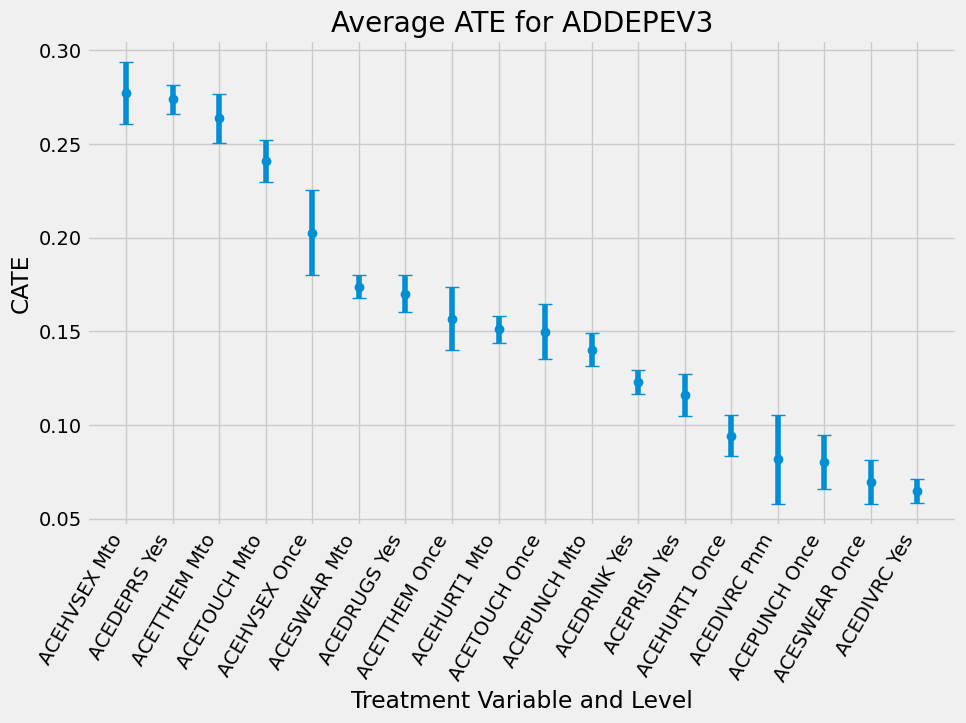

In [15]:
data = pd.read_csv('output.csv')

# Identify numeric columns
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()

# Calculate averages only for numeric columns
averages = data.groupby(['Treatment Variable', 'Treatment Level', 'Target Variable'])[numeric_cols].mean().reset_index()
print(averages.columns)
# Display the averages for verification
addepev3_data = averages[averages['Target Variable'] == 'ADDEPEV3']
# Sort the data by 'ATE' column in descending order
addepev3_data = addepev3_data.sort_values('ATE', ascending=False)

def abbreviate_if_needed(name):
    words = name.split()
    if len(words) > 1:
        return ''.join(word[0] for word in words)
    else:
        return name

# Apply the function to the 'Treatment Level' column
addepev3_data['Treatment Level'] = addepev3_data['Treatment Level'].apply(abbreviate_if_needed)

# Plotting
plt.figure(figsize=(10, 6))
plt.errorbar(addepev3_data['Treatment Variable'] + ' ' + addepev3_data['Treatment Level'],
             addepev3_data['ATE'],
             yerr=[addepev3_data['ATE'] - addepev3_data['Lower Bound'], addepev3_data['Upper Bound'] - addepev3_data['ATE']],
             fmt='o', capsize=5)
# Print out each treatment level and its average treatment affect
for i, row in addepev3_data.iterrows():
    print(f"{row['Treatment Variable']} {row['Treatment Level']}: {row['ATE']}")
plt.xticks(rotation=60, ha='right')
plt.xlabel('Treatment Variable and Level')
plt.ylabel('CATE')
plt.title('Average CATE for ADDEPEV3')
plt.savefig('average_ate_addepev3.png')
plt.show()



ACEHVSEX Mto: 5.117726120386505
ACETTHEM Mto: 4.436983648695192
ACEDEPRS Yes: 4.251373927458703
ACETOUCH Mto: 3.908931354007752
ACEHVSEX Once: 3.848254954222341
ACEDRUGS Yes: 3.4675940931203852
ACESWEAR Mto: 3.279307740670879
ACEPRISN Yes: 3.026299407970457
ACEHURT1 Mto: 2.94658393392571
ACEPUNCH Mto: 2.740303008655297
ACETTHEM Once: 2.6652217227056445
ACEDRINK Yes: 2.509636269163104
ACETOUCH Once: 2.4940377098089135
ACEHURT1 Once: 1.428103271414662
ACEPUNCH Once: 1.3699439901667498
ACESWEAR Once: 1.21820291203713
ACEDIVRC Pnm: 1.023054211803831
ACEDIVRC Yes: -1.3146655990438365


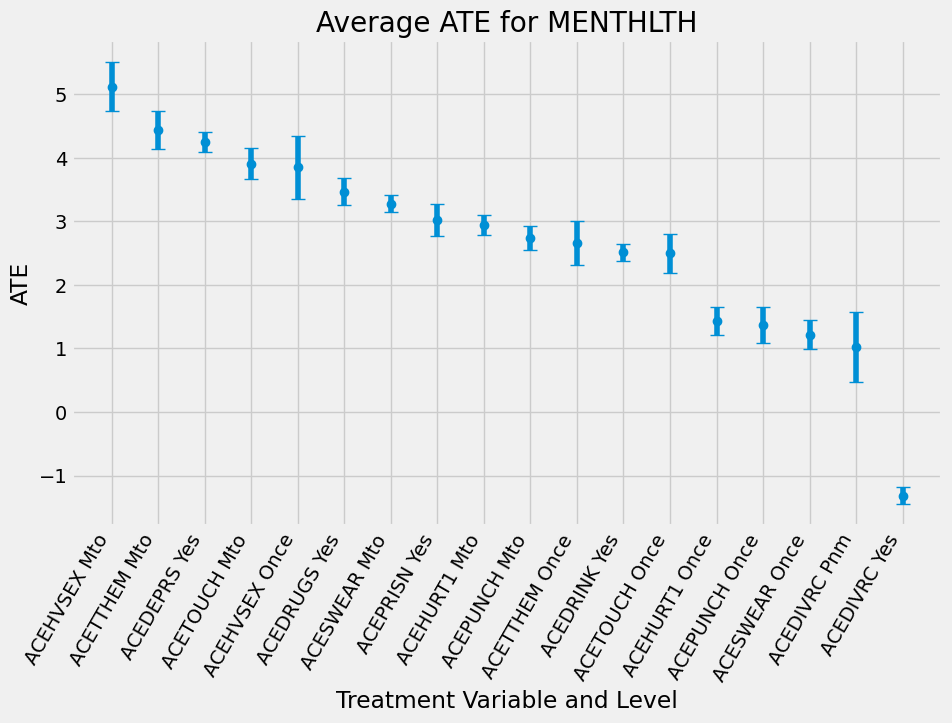

In [ ]:
# Filter data for MENTHLTH
menthlth_data = averages[averages['Target Variable'] == 'MENTHLTH']
# Sort the data by 'ATE' column in descending order
menthlth_data = menthlth_data.sort_values('ATE', ascending=False)
# Abbreviate the 'Treatment Level' column
menthlth_data['Treatment Level'] = menthlth_data['Treatment Level'].apply(abbreviate_if_needed)

# Plotting
plt.figure(figsize=(10, 6))
plt.errorbar(menthlth_data['Treatment Variable'] + ' ' + menthlth_data['Treatment Level'],
             menthlth_data['ATE'],
             yerr=[menthlth_data['ATE'] - menthlth_data['Lower Bound'], menthlth_data['Upper Bound'] - menthlth_data['ATE']],
             fmt='o', capsize=5)
# Print out each treatment level and its average treatment affect
for i, row in menthlth_data.iterrows():
    print(f"{row['Treatment Variable']} {row['Treatment Level']}: {row['ATE']}")
plt.xticks(rotation=60, ha='right')
plt.xlabel('Treatment Variable and Level')
plt.ylabel('CATE')
plt.title('Average CATE for MENTHLTH')
# plt.tight_layout()
# Dowload the plot as an image
plt.savefig('average_ate_menthlth.png')
plt.show()



In [ ]:
# # Declare the feature columns
# feature_cols = ['_AGE_G', '_SEX', '_EDUCAG', '_INCOMG1']

# # Declare the target columns
# target_cols = ['ADDEPEV3', 'MENTHLTH']

# # Declare the treatment columns
# treatment_cols = ['ACEDEPRS', 'ACEDRINK', 'ACEDRUGS', 'ACEPRISN',
#        'ACEDIVRC', 'ACEPUNCH', 'ACEHURT1', 'ACESWEAR', 'ACETOUCH', 'ACETTHEM',
#        'ACEHVSEX']

# # Declare the sample weights column
# sample_weights_col = 'FINALWT'

# # Recode the target columns
# for target in target_cols:
#     ace_data = recode_target(ace_data, target)

# # Iterate over all combinations of target and treatment columns
# for target in target_cols:
#     for treatment in treatment_cols:
#         print(f"Performing analysis for target {target} and treatment {treatment}")
#         perform_analysis(ace_data, target, treatment, feature_cols, sample_weights_col)

Copilot on Interpretation:

For the binary target ADDEPEV3 with treatment ACEDEPRS:

The Average Treatment Effect (ATE) is a measure of the difference in mean (average) outcomes between units that received the treatment and those that did not. In this case, the ATE is the difference in the average outcome of ADDEPEV3 (whether a person has experienced a depressive episode) between those who have experienced ACEDEPRS (a form of adverse childhood experience) and those who have not.

The results from the different models (LRS Regressor, Neural Network, BaseXRegressor using XGBoost, and BaseRRegressor using XGBoost) are all around 0.25 to 0.30. This suggests that, on average, experiencing ACEDEPRS increases the likelihood of having a depressive episode (ADDEPEV3) by about 25% to 30%. The numbers in parentheses are the lower and upper bounds of a 95% confidence interval for the ATE, indicating the range within which we can be 95% confident that the true ATE lies.

In simpler terms: These results suggest that people who have experienced this particular adverse childhood experience are about 25% to 30% more likely to have had a depressive episode.

For the continuous target MENTHLTH with treatment ACEHVSEX:

The interpretation is similar, but now the ATE represents the difference in the average number of days of poor mental health (MENTHLTH) between those who have experienced ACEHVSEX (another form of adverse childhood experience) and those who have not.

The results from the different models suggest that, on average, experiencing ACEHVSEX increases the number of days of poor mental health by about 10 to 13 days. The BaseRRegressor using XGBoost model seems to be an outlier with an ATE of 0.26, which might suggest some issue with the model or the data.

In simpler terms: These results suggest that people who have experienced this particular adverse childhood experience have, on average, 10 to 13 more days of poor mental health.

Simple Example with Drugs as Treatment and Mental Health as Response

In [ ]:
# # filter out rows that have `nan` values in the 'ACEDRUGS' or 'MENTHLTH' columns
# ace_data = ace_data.dropna(subset=['ACEDRUGS', 'MENTHLTH'])

# # Filter the dataset to only include rows where the 'ACEDRUGS' column is less than 2
# ace_data = ace_data[ace_data['ACEDRUGS'] < 3] # Only two levels of treatment

# # Declare the treatment
# treatment = ace_data['ACEDRUGS']

# # Declare the target
# # y = ace_data['MENTHLTH']
# y = ace_data['ACEDEPRS']

# # # Subtract 1 from the treatment column
# treatment = treatment - 1 
# # TODO I need to confirm what 0 and 1 should mean for CausalML i.e. YES and NO or NO and YES

# print(treatment.unique())

# # Declare X
# X = ace_data[['_AGE_G', '_SEX', '_EDUCAG', '_INCOMG1']]

# # Print the shapes of X, treatment, and y
# print(X.shape)
# print(y.shape)
# print(treatment.shape)

# Propensity Score
Propensity score, which is the probability of receiving the treatment given the observed features.

In the context of causal inference, the propensity score is a balancing score: conditional on the propensity score, the distribution of observed covariates will be the same between treated and untreated subjects.

To create e with non-synthetic data, you would typically use a binary classification model where the features are your covariates and the target is whether or not the subject received treatment. The predicted probability of receiving treatment is your propensity score.

This code fits a logistic regression model to predict the treatment given the features, and then uses this model to compute the propensity score. Note that this is a very basic example and in practice you might need to consider more sophisticated models or methods to estimate the propensity score, depending on the complexity of your data.

In [ ]:
# # Calculate the propensity score (basic and prompt engineered could be wrong)
# model = LogisticRegression()
# model.fit(X, y)

# # The propensity score
# e = model.predict_proba(X)[:, 1]
# print(len(e))

In [ ]:
# learner_s = LRSRegressor()
# ate_s = learner_s.estimate_ate(X=X, treatment=treatment, y=y)
# print(ate_s)
# print('ATE estimate: {:.03f}'.format(ate_s[0][0]))
# print('ATE lower bound: {:.03f}'.format(ate_s[1][0]))
# print('ATE upper bound: {:.03f}'.format(ate_s[2][0]))


In [ ]:
# nn = MLPTRegressor(hidden_layer_sizes=(10, 10),
#                  learning_rate_init=.1,
#                  early_stopping=True,
#                  random_state=42)
# te, lb, ub = nn.estimate_ate(X, treatment, y)
# print('Average Treatment Effect (Neural Network (MLP)): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

In [ ]:
# xl = BaseXRegressor(learner=XGBRegressor(random_state=42))
# te, lb, ub = xl.estimate_ate(X, treatment, y, e)
# print('Average Treatment Effect (BaseXRegressor using XGBoost): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

In [ ]:
# rl = BaseRRegressor(learner=XGBRegressor(random_state=42))
# te, lb, ub =  rl.estimate_ate(X=X, p=e, treatment=treatment, y=y)
# print('Average Treatment Effect (BaseRRegressor using XGBoost): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))